In [1]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math

### Load model

In [2]:
name = "undamped_k12"

undamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
undamped_name = f"model_{name}.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

12 True True True 1.0 16 [256, 256, 512]


### Problem definition

In [3]:
N = 5120
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)

In [4]:
w_list_transfer = [1]
zeta_list = [0]

def cos_1st_pass(t):
    return np.cos(6*t)            

def cos_1st_pass_2D(t):
    return np.stack((np.zeros_like(t), np.cos(6*t)), axis=1)

ic_list = [[1, 0]]

epsilon_list = [0.8]
p_list = [8]

### Compute latent representation H

In [5]:
H_dict = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

In [6]:
w_sol_1st_pass = []
NN_TL_solution_LPM_1st_pass, perturbation_solution_LPM_1st_pass, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, [cos_1st_pass_2D], H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="LPM", w_sol = w_sol_1st_pass)
NN_TL_solution_LPM_1st_pass = NN_TL_solution_LPM_1st_pass.squeeze()

In [7]:
w_1st_pass = LPM.calculate_w_series(w_sol_1st_pass[0], epsilon_list[0], rwtol=1e-12)[-1]
t_eval_1st_pass = t_eval / w_1st_pass

In [8]:
ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta_list[0], forcing_1D=cos_1st_pass, q=3, epsilon=epsilon_list[0])
numerical_1st_pass = numerical.solve_ode_equation(ode, (t_eval_1st_pass[0], t_eval_1st_pass[-1]), t_eval_1st_pass, ic_list[0])

In [9]:
def cos_2nd_pass(t):
    return np.cos(6*t/w_1st_pass)            

def cos_2nd_pass_2D(t):
    return np.stack((np.zeros_like(t), np.cos(6*t/w_1st_pass)), axis=1)

In [10]:
w_sol_2nd_pass = []
NN_TL_solution_LPM_2nd_pass, perturbation_solution_LPM_2nd_pass, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, [cos_2nd_pass_2D], H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="LPM", w_sol = w_sol_2nd_pass, invert=False)
NN_TL_solution_LPM_2nd_pass = NN_TL_solution_LPM_2nd_pass.squeeze()

In [11]:
w_2nd_pass = LPM.calculate_w_series(w_sol_2nd_pass[0], epsilon_list[0], rwtol=1e-12)[-1]
t_eval_2nd_pass = t_eval / w_2nd_pass

series has diverged for order p = 8


In [12]:
numerical_2nd_pass = numerical.solve_ode_equation(ode, (t_eval_2nd_pass[0], t_eval_2nd_pass[-1]), t_eval_2nd_pass, ic_list[0])

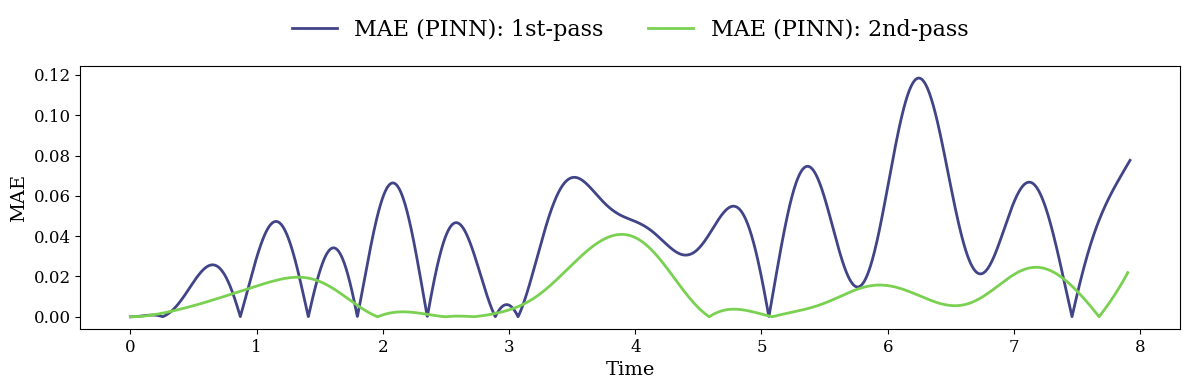

In [14]:
LPM.plot_compare_1st_2nd_pass(numerical_1st_pass, numerical_2nd_pass, NN_TL_solution_LPM_1st_pass, NN_TL_solution_LPM_2nd_pass, t_eval_1st_pass, t_eval_2nd_pass)